<a href="https://colab.research.google.com/github/t13017/Titanic_Survival_Prediction-/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq

Selecting previously unselected package libxtst6:amd64.
(Reading database ... 120493 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u372-ga~us1-0ubuntu1~22.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u372-ga~us1-0ubuntu1~22.04) ...
Selecting previously unselected package openjdk-8-jdk-headless:amd64.
Preparing to unpack .../openjdk-8-jdk-headless_8u372-ga~us1-0ubuntu1~22.04_amd64.deb ...
Unpacking openjdk-8-jdk-headless:amd64 (8u372-ga~us1-0ubuntu1~22.04) ...
Setting up libxtst6:amd64 (2:1.2.3-1build4) ...
Setting up openjdk-8-jre-headless:amd64 (8u372-ga~us1-0ubuntu1~22.04) ...
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/orbd to provide /usr/bin/orbd (orbd) in auto mode
update-alternatives: using /usr/lib/jvm/java-8-openjdk

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285397 sha256=592c1f8c8b2220baf5e35af7d056b95c1811fd387674b4363df000d8da671ef2
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, mean
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.getOrCreate()

In [ ]:
titanic_df = spark.read.csv('/content/titanic.csv', header=True, inferSchema=True)

Handling missing values

In [ ]:
# Count missing values in each column
titanic_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in titanic_df.columns]).show()

# Replace missing values in 'Age' column with the mean value
mean_age = titanic_df.select(mean('Age')).first()[0]
titanic_df = titanic_df.na.fill({'Age': mean_age})

# Replace missing values in 'Embarked' column with the most frequent value
most_frequent_embarked = titanic_df.groupBy('Embarked').count().orderBy(col('count').desc()).first()[0]
titanic_df = titanic_df.na.fill({'Embarked': most_frequent_embarked})

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [ ]:
#converting categorical variables into integer values
# StringIndexer for 'Sex' column
sex_indexer = StringIndexer(inputCol='Sex', outputCol='SexIndex')
titanic_df = sex_indexer.fit(titanic_df).transform(titanic_df)

# StringIndexer for 'Embarked' column
embarked_indexer = StringIndexer(inputCol='Embarked', outputCol='EmbarkedIndex')
titanic_df = embarked_indexer.fit(titanic_df).transform(titanic_df)

In [ ]:
titanic_df.show()

+-----------+--------+------+--------------------+------+-----------------+-----+-----+----------------+-------+-----+--------+--------+-------------+
|PassengerId|Survived|Pclass|                Name|   Sex|              Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|SexIndex|EmbarkedIndex|
+-----------+--------+------+--------------------+------+-----------------+-----+-----+----------------+-------+-----+--------+--------+-------------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|             22.0|    1|    0|       A/5 21171|   7.25| null|       S|     0.0|          0.0|
|          2|       1|     1|Cumings, Mrs. Joh...|female|             38.0|    1|    0|        PC 17599|71.2833|  C85|       C|     1.0|          1.0|
|          3|       1|     3|Heikkinen, Miss. ...|female|             26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|     1.0|          0.0|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|             35.0|    1|    0|       

In [ ]:
import pandas as pd

# Convert Spark DataFrame to pandas DataFrame
pandas_df = titanic_df.toPandas()

# Save pandas DataFrame as CSV file
pandas_df.to_csv('preprocessed_titanic.csv', index=False)

Exploratory Data Analysis

In [ ]:
survivors_percentage = titanic_df.filter(titanic_df.Survived == 1).count() / titanic_df.count() * 100
print("Percentage of survivors: {:.2f}%".format(survivors_percentage))

Percentage of survivors: 38.38%


<ipython-input-12-f96c5b8e4595>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = heatmap_data.corr()


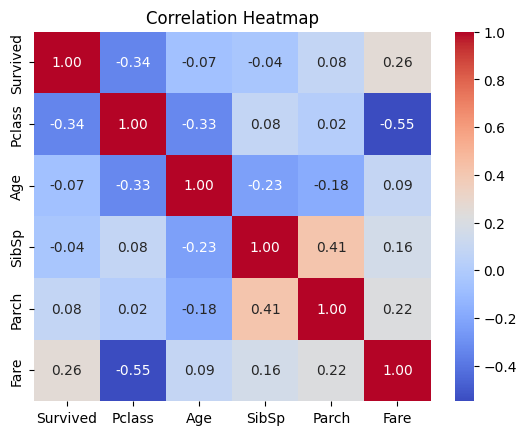

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the DataFrame to Pandas
pandas_df = titanic_df.toPandas()

# Select the columns for the heatmap
heatmap_data = pandas_df[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]

# Compute the correlation matrix
correlation_matrix = heatmap_data.corr()

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# New Section

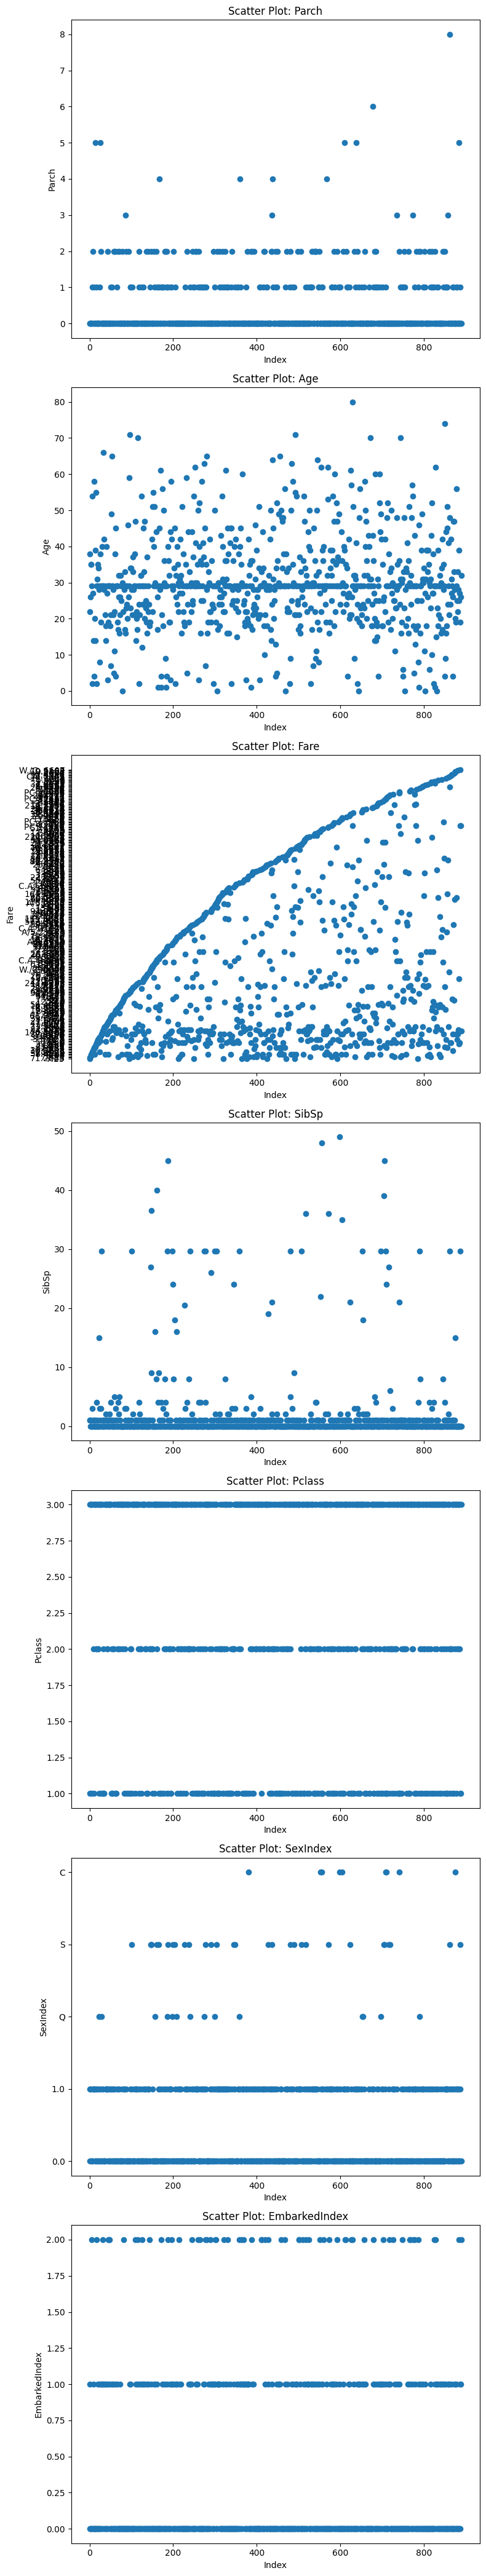

In [ ]:
import matplotlib.pyplot as plt

preprocessed_titanic_df = spark.read.csv('/content/preprocessed_titanic.csv', header=True, inferSchema=True)

# Convert "Age" column to integers
preprocessed_titanic_df = preprocessed_titanic_df.withColumn('Age', preprocessed_titanic_df['Age'].cast('int'))

# Select the columns for scatter plots
columns = ['Parch', 'Age', 'Fare', 'SibSp', 'Pclass', 'SexIndex', 'EmbarkedIndex']

# Create a figure with subplots
fig, axs = plt.subplots(len(columns), figsize=(8, 6 * len(columns)))

# Generate scatter plots for each column
for i, col in enumerate(columns):
    # Extract the column values as a list
    values = preprocessed_titanic_df.select(col).rdd.flatMap(lambda x: x).collect()

    # Generate scatter plot
    axs[i].scatter(range(len(values)), values)
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel(col)
    axs[i].set_title(f'Scatter Plot: {col}')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the scatter plots
plt.show()


In [27]:
!pip install --upgrade pandas-profiling

  Attempting uninstall: wordcloud
    Found existing installation: wordcloud 1.8.2.2
    Uninstalling wordcloud-1.8.2.2:
      Successfully uninstalled wordcloud-1.8.2.2


In [31]:
import pandas as pd
import pandas_profiling

# Load the Titanic dataset into a pandas DataFrame
titanic_df = pd.read_csv('titanic.csv')

titanic_df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [ ]:
import pandas as pd
import pandas_profiling

# Load the Titanic dataset into a pandas DataFrame
titanic_df = pd.read_csv('titanic.csv')

# Generate the report using pandas_profiling
report = pandas_profiling.ProfileReport(titanic_df)

# Save the report as an HTML file
report.to_file("titanic_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
import pandas as pd
import pandas_profiling

# Load the Titanic dataset into a pandas DataFrame
titanic_df = pd.read_csv('preprocessed_titanic.csv')

titanic_df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexIndex,EmbarkedIndex
count,891.000000,891.000000,891.000000,891,891,891.000000,891.000000,891.000000,891,891.000000,204,891,891.000000,891.000000
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3,NaN,NaN
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S,NaN,NaN
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,646,NaN,NaN
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN,0.352413,0.361392
std,257.353842,0.486592,0.836071,NaN,NaN,13.002015,1.102743,0.806057,NaN,49.693429,NaN,NaN,0.477990,0.635673
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,NaN,22.000000,0.000000,0.000000,NaN,7.910400,NaN,NaN,0.000000,0.000000
50%,446.000000,0.000000,3.000000,NaN,NaN,29.699118,0.000000,0.000000,NaN,14.454200,NaN,NaN,0.000000,0.000000
75%,668.500000,1.000000,3.000000,NaN,NaN,35.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN,1.000000,1.000000


In [ ]:
import pandas as pd
import pandas_profiling

# Load the Titanic dataset into a pandas DataFrame
titanic_df = pd.read_csv('preprocessed_titanic.csv')

# Generate the report using pandas_profiling
report = pandas_profiling.ProfileReport(titanic_df)

# Save the report as an HTML file
report.to_file("preprocessed_titanic_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
import pandas as pd
import pandas_profiling

# Load the Titanic dataset into a pandas DataFrame
titanic_df = pd.read_csv('preprocessed_titanic_test.csv')

# Generate the report using pandas_profiling
report = pandas_profiling.ProfileReport(titanic_df)

# Save the report as an HTML file
report.to_file("preprocessed_titanic_test_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt

# Load the Titanic dataset into a pandas DataFrame
titanic_df = pd.read_csv('preprocessed_titanic.csv')

# Convert 'Survived' column to categorical type for better visualization
titanic_df['Survived'] = titanic_df['Survived'].astype('category')

# Generate the report using pandas-profiling
report = pandas_profiling.ProfileReport(titanic_df)

# Get the list of variables (except 'Survived')
variables = [var for var in titanic_df.columns if var != 'Survived']

# Loop through each variable and plot a graph with 'Survived'
for variable in variables:
    plt.figure(figsize=(8, 4))
    if titanic_df[variable].dtype == 'object':
        sns.countplot(x=variable, hue='Survived', data=titanic_df)
    else:
        sns.barplot(x=variable, y='Survived', data=titanic_df)
    plt.title(f'{variable} vs Survived')
    plt.xlabel(variable)
    plt.ylabel('Survived')
    plt.tight_layout()
    plt.savefig(f'{variable}_vs_Survived.png')
    plt.close()

# Save the report as an HTML file
report.to_file("titanic_report_S.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

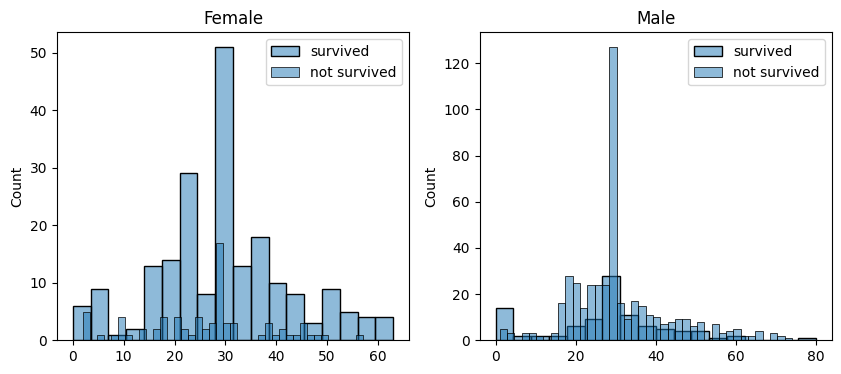

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

survived = 'survived'
not_survived = 'not survived'

# Filter the DataFrame for women and men
women = preprocessed_titanic_df.filter(preprocessed_titanic_df['SexIndex'] == 1)
men = preprocessed_titanic_df.filter(preprocessed_titanic_df['SexIndex'] == 0)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot for females
ax = sns.histplot(women.filter(women['Survived'] == 1).select('Age').dropna().toPandas(),
                  bins=18, label=survived, ax=axes[0], kde=False)
ax = sns.histplot(women.filter(women['Survived'] == 0).select('Age').dropna().toPandas(),
                  bins=40, label=not_survived, ax=axes[0], kde=False)
ax.legend()
ax.set_title('Female')

# Plot for males
ax = sns.histplot(men.filter(men['Survived'] == 1).select('Age').dropna().toPandas(),
                  bins=18, label=survived, ax=axes[1], kde=False)
ax = sns.histplot(men.filter(men['Survived'] == 0).select('Age').dropna().toPandas(),
                  bins=40, label=not_survived, ax=axes[1], kde=False)
ax.legend()
ax.set_title('Male')

plt.show()

<ipython-input-22-7363a1ba163a>:26: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


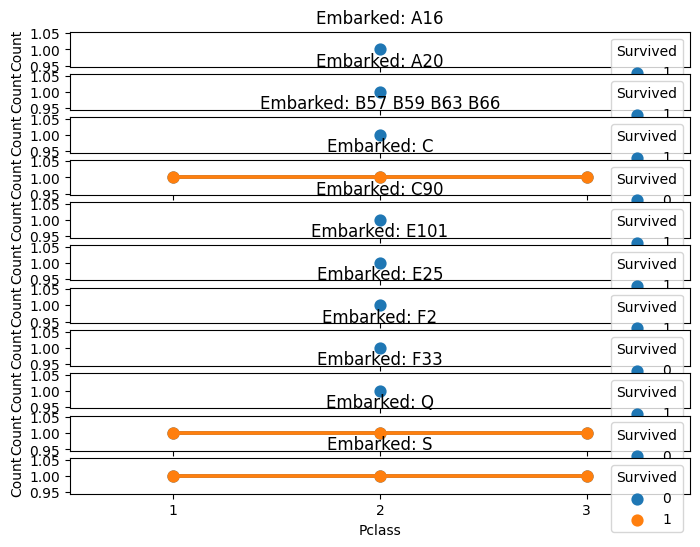

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

titanic_df = spark.read.csv('/content/preprocessed_titanic.csv', header=True, inferSchema=True)

# Convert the grouped_data DataFrame to a Pandas DataFrame
grouped_data = grouped_data.groupby(['Embarked', 'Pclass', 'Survived', 'Sex']).count().reset_index()

# Create subplots based on 'Embarked' using matplotlib
fig, axes = plt.subplots(len(grouped_data['Embarked'].unique()), 1, figsize=(8, 6), sharey=True)
for i, embarked_value in enumerate(grouped_data['Embarked'].unique()):
    ax = axes[i]
    data = grouped_data[grouped_data['Embarked'] == embarked_value]

    # Plot a pointplot for each 'Embarked' value
    sns.pointplot(x='Pclass', y='count', hue='Survived', data=data, ax=ax)
    ax.set_title(f'Embarked: {embarked_value}')
    ax.set_ylabel('Count')
    ax.set_xlabel('Pclass')

# Add a legend
plt.legend(title='Survived', loc='upper right')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


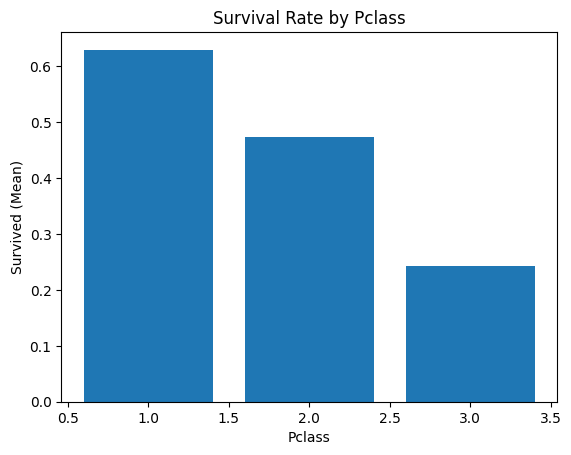

In [ ]:
from pyspark.sql import functions as F
# Group the data by 'Pclass' and calculate the mean of 'Survived'
grouped_data = titanic_df.groupby('Pclass').agg(F.mean('Survived').alias('Survived_mean')).toPandas()

# Create a bar plot
plt.bar(grouped_data['Pclass'], grouped_data['Survived_mean'])

# Set plot labels and title
plt.xlabel('Pclass')
plt.ylabel('Survived (Mean)')
plt.title('Survival Rate by Pclass')

# Show the plot
plt.show()


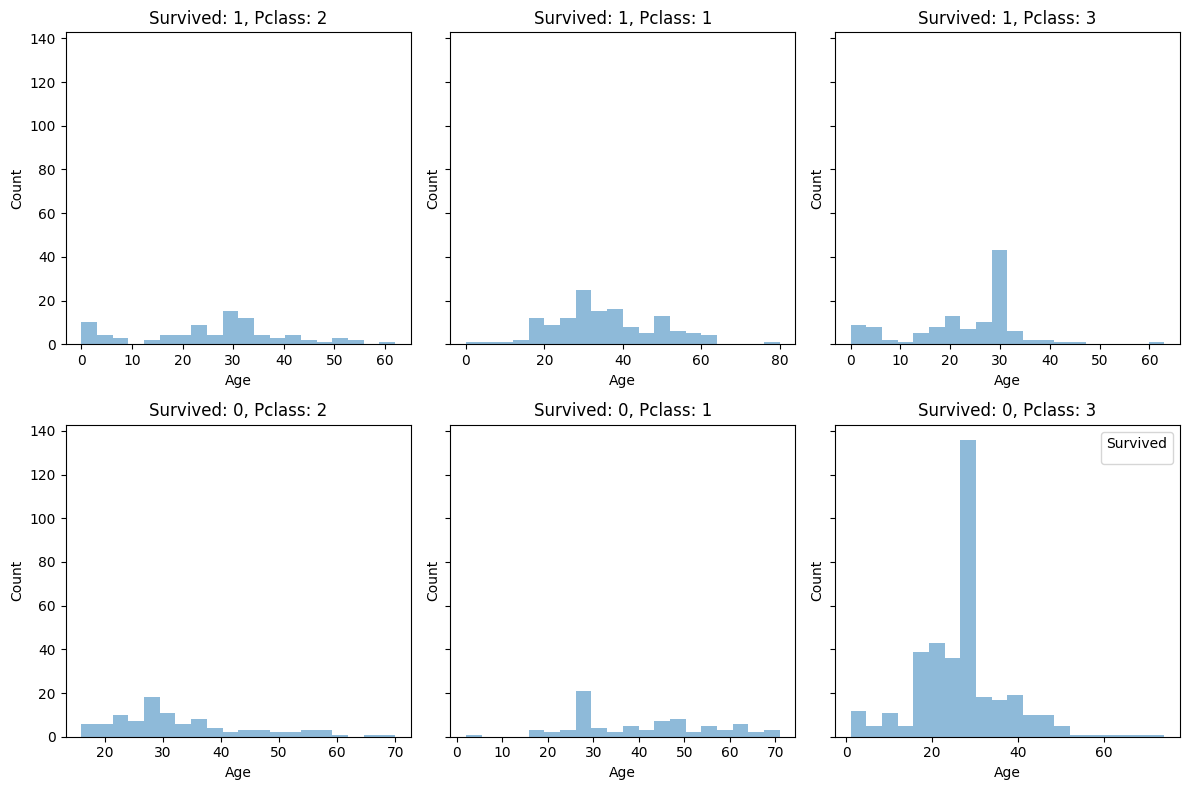

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the data by 'Survived' and 'Pclass' and calculate the count of each combination
grouped_data = titanic_df.groupby(['Survived', 'Pclass']).count().toPandas()

# Create subplots based on 'Survived' and 'Pclass' using matplotlib
fig, axes = plt.subplots(len(grouped_data['Survived'].unique()), len(grouped_data['Pclass'].unique()), figsize=(12, 8), sharey=True)

# Iterate through each combination of 'Survived' and 'Pclass' and plot the histogram
for i, survived_value in enumerate(grouped_data['Survived'].unique()):
    for j, pclass_value in enumerate(grouped_data['Pclass'].unique()):
        ax = axes[i, j]
        data = titanic_df.filter((titanic_df['Survived'] == survived_value) & (titanic_df['Pclass'] == pclass_value)).select(titanic_df['Age'].cast('int')).dropna().toPandas()

        # Plot the histogram
        ax.hist(data['Age'], alpha=0.5, bins=20)
        ax.set_title(f'Survived: {survived_value}, Pclass: {pclass_value}')
        ax.set_xlabel('Age')
        ax.set_ylabel('Count')

# Add a legend
plt.legend(title='Survived', loc='upper right')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


Feature Engineering

In [ ]:
titanic1_df = spark.read.csv('/content/preprocessed_titanic.csv', header=True, inferSchema=True)

In [ ]:
# Drop the 'Cabin' and 'Ticket' columns
titanic1_df = titanic1_df.drop('Cabin', 'Ticket')

In [ ]:
from pyspark.sql.functions import col, regexp_extract

# Create a 'FamilySize' feature by combining 'SibSp' and 'Parch' columns
titanic1_df = titanic1_df.withColumn('FamilySize', col('SibSp') + col('Parch') + 1)

In [ ]:
# Create a 'IsAlone' feature based on 'SibSp' and 'Parch' columns
titanic1_df = titanic1_df.withColumn('IsAlone', when((col('SibSp') + col('Parch')) == 0, 1).otherwise(0))

In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.feature import Bucketizer, StringIndexer

# Convert 'Age' column to double type
titanic1_df = titanic1_df.withColumn('Age', titanic1_df['Age'].cast('double'))

# Define the age bins and labels
age_bins = [-float('inf'), 0, 5, 12, 18, 24, 35, 60, float('inf')]
age_labels = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']

# Create a Bucketizer to categorize the 'Age' column
bucketizer = Bucketizer(splits=age_bins, inputCol='Age', outputCol='age_labels')
titanic1_df = bucketizer.transform(titanic1_df)

In [ ]:
titanic1_df.show()

+-----------+--------+------+--------------------+------+-----------------+-----+-----+-------+--------+--------+-------------+----------+-------+----------+
|PassengerId|Survived|Pclass|                Name|   Sex|              Age|SibSp|Parch|   Fare|Embarked|SexIndex|EmbarkedIndex|FamilySize|IsAlone|age_labels|
+-----------+--------+------+--------------------+------+-----------------+-----+-----+-------+--------+--------+-------------+----------+-------+----------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|             22.0|  1.0|    0|   7.25|       S|     0.0|          0.0|       2.0|      0|       4.0|
|          2|       1|     1|Cumings, Mrs. Joh...|female|             38.0|  1.0|    0|71.2833|       C|     1.0|          1.0|       2.0|      0|       6.0|
|          3|       1|     3|Heikkinen, Miss. ...|female|             26.0|  0.0|    0|  7.925|       S|     1.0|          0.0|       1.0|      1|       5.0|
|          4|       1|     1|Futrelle, Mrs. Ja...|fe

In [ ]:
# Filter rows where "Sex" column contains values other than "male" and "female"
filtered_df = titanic1_df.filter((titanic1_df.Sex == "male") | (titanic1_df.Sex == "female"))

# Show the filtered DataFrame
filtered_df.show()

pandas_df = filtered_df.toPandas()

pandas_df.to_csv('FE_titanic.csv', index=False)


+-----------+--------+------+--------------------+------+-----------------+-----+-----+-------+--------+--------+-------------+----------+-------+----------+
|PassengerId|Survived|Pclass|                Name|   Sex|              Age|SibSp|Parch|   Fare|Embarked|SexIndex|EmbarkedIndex|FamilySize|IsAlone|age_labels|
+-----------+--------+------+--------------------+------+-----------------+-----+-----+-------+--------+--------+-------------+----------+-------+----------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|             22.0|  1.0|    0|   7.25|       S|     0.0|          0.0|       2.0|      0|       4.0|
|          2|       1|     1|Cumings, Mrs. Joh...|female|             38.0|  1.0|    0|71.2833|       C|     1.0|          1.0|       2.0|      0|       6.0|
|          3|       1|     3|Heikkinen, Miss. ...|female|             26.0|  0.0|    0|  7.925|       S|     1.0|          0.0|       1.0|      1|       5.0|
|          4|       1|     1|Futrelle, Mrs. Ja...|fe

In [30]:
import pandas as pd
import pandas_profiling

# Load the Titanic dataset into a pandas DataFrame
titanic_df = pd.read_csv('FE_titanic.csv')

# Generate the report using pandas_profiling
report = pandas_profiling.ProfileReport(titanic_df)

# Save the report as an HTML file
report.to_file("FE_titanic_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

**XGBoost**

In [ ]:
!pip install xgboost

In [4]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import joblib

# Load the Titanic dataset into a pandas DataFrame
titanic_df = pd.read_csv('FE_titanic.csv')

# Define the features and target variable
features = ['Pclass', 'SexIndex', 'Age', 'SibSp', 'Parch', 'Fare', 'EmbarkedIndex']
target = 'Survived'

# Split the data into features and target
X = titanic_df[features]
y = titanic_df[target]

# Split the data into training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the XGBoost classifier
clf = xgb.XGBClassifier()

# Fit the classifier on the training dataset
clf.fit(X_train, y_train)

# Make predictions on the test dataset
predictions = clf.predict(X_test)

# Calculate the F1 score on the test dataset
f1 = f1_score(y_test, predictions)

# Print the F1 score
print("F1 Score on Test Dataset:", f1)

# Save the trained XGBoost model to a joblib file
joblib.dump(clf, 'xgboost_model1.joblib')

F1 Score on Test Dataset: 0.6956521739130435


['xgboost_model1.joblib']

In [23]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score
import joblib

# Load the Titanic dataset into a pandas DataFrame
titanic_df = pd.read_csv('FE_titanic.csv')

# Define the features and target variable
features = ['Pclass', 'Age', 'Fare', 'Parch', 'SibSp', 'SexIndex', 'EmbarkedIndex']
target = 'Survived'

# Split the data into features and target
X = titanic_df[features]
y = titanic_df[target]

# Split the data into training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create the XGBoost classifier
clf = xgb.XGBClassifier()

# Define the hyperparameter grid for tuning
param_grid = {
    'max_depth': [4, 5, 6, 7],
    'learning_rate': [0.01, 0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 150, 200],
    'subsample': [1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding F1 score
best_params = grid_search.best_params_
best_f1 = grid_search.best_score_

# Train the final model with the best hyperparameters
final_clf = xgb.XGBClassifier(**best_params)
final_clf.fit(X_train, y_train)

# Save the trained model using joblib.dump()
joblib.dump(final_clf, 'xgboost_model.joblib')

# Make predictions on the test dataset
y_pred_test = final_clf.predict(X_test)

# Calculate the F1 score on the test dataset
f1_test = f1_score(y_test, y_pred_test)

# Print the best hyperparameters and the corresponding F1 score
print("Best Hyperparameters:", best_params)
print("Best F1 Score:", best_f1)
print("F1 Score on Test Dataset:", f1_test)

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Best F1 Score: 0.7586888696206378
F1 Score on Test Dataset: 0.6782608695652174


In [24]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
import joblib

# Load the Titanic test dataset
titanic_test_df = pd.read_csv('preprocessed_titanic_test.csv')

# Define the features for the test dataset (should be the same as in training dataset)
features_test = ['Pclass', 'Age', 'Fare', 'Parch', 'SibSp', 'SexIndex', 'EmbarkedIndex']

# Select features for the test dataset
X_test = titanic_test_df[features_test]

# Load the trained logistic regression model
logistic_model = joblib.load('xgboost_model.joblib')

# Make predictions on the test dataset
y_pred_test = logistic_model.predict(X_test)

# Add the predictions to the test dataset
titanic_test_df['Survived'] = y_pred_test

# Save the results to a .csv file
titanic_test_df[['PassengerId', 'Survived']].to_csv('XGBoost_titanic_test_predictions.csv', index=False)

# Calculate the survival percentage
survived_percentage = 100 * sum(y_pred_test) / len(y_pred_test)
print(f"Survival Percentage on Test Dataset: {survived_percentage:.2f}%")


Survival Percentage on Test Dataset: 30.14%


**Logistic Regression**

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import joblib

# Load the Titanic dataset
titanic_df = pd.read_csv('FE_titanic.csv')

# Define the features and target variable
features = ['Pclass', 'Age', 'Fare', 'Parch', 'SibSp', 'SexIndex', 'EmbarkedIndex']
target = 'Survived'

# Split the data into features and target
X = titanic_df[features]
y = titanic_df[target]

# Split the data into training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Logistic Regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Save the trained model
joblib.dump(logistic_model, 'logistic_regression_model1.joblib')

# Make predictions on the test dataset
y_pred = logistic_model.predict(X_test)

# Evaluate the model on the test dataset using accuracy metric
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test dataset: {accuracy}")

Accuracy on the test dataset: 0.7976190476190477


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import joblib

# Load the Titanic dataset
titanic_df = pd.read_csv('FE_titanic.csv')

# Define the features and target variable
features = ['Pclass', 'Age', 'Fare', 'Parch', 'SibSp', 'SexIndex', 'EmbarkedIndex']
target = 'Survived'

# Split the data into features and target
X = titanic_df[features]
y = titanic_df[target]

# Split the data into training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameters to tune
param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'penalty': ['l2'],  # Corrected penalty values
    'solver': ['lbfgs', 'liblinear']  # Set 'liblinear' when using 'l1' penalty
}

# Create the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(logistic_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Save the best model
joblib.dump(best_model, 'logistic_regression_best_model.joblib')

# Make predictions on the test dataset using the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model on the test dataset using accuracy metric
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test dataset with the best model: {accuracy}")

Accuracy on the test dataset with the best model: 0.7857142857142857


In [33]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import joblib

# Load the Titanic test dataset
titanic_test_df = pd.read_csv('preprocessed_titanic_test.csv')

# Define the features for the test dataset (should be the same as in training dataset)
features_test = ['Pclass', 'Age', 'Fare', 'Parch', 'SibSp', 'SexIndex', 'EmbarkedIndex']

# Select features for the test dataset
X_test = titanic_test_df[features_test]

# Load the trained logistic regression model
logistic_model = joblib.load('logistic_regression_best_model.joblib')

# Make predictions on the test dataset
y_pred_test = logistic_model.predict(X_test)

# Add the predictions to the test dataset
titanic_test_df['Survived'] = y_pred_test

# Save the results to a .csv file
titanic_test_df[['PassengerId', 'Survived']].to_csv('LR_titanic_test_predictions.csv', index=False)

# Calculate the survival percentage
survived_percentage = 100 * sum(y_pred_test) / len(y_pred_test)
print(f"Survival Percentage on Test Dataset: {survived_percentage:.2f}%")

Survival Percentage on Test Dataset: 32.54%


**Random Forest**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
import joblib

# Load the Titanic dataset
titanic_df = pd.read_csv('FE_titanic.csv')

# Define the features and target variable
features = ['Pclass', 'Age', 'Fare', 'Parch', 'SibSp', 'SexIndex', 'EmbarkedIndex']
target = 'Survived'

# Split the data into features and target
X = titanic_df[features]
Y = titanic_df[target]

# Split the data into training and testing sets (80% for training, 20% for testing)
X_train, X_test, Y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train the Random Forest classifier
random_forest_model = RandomForestClassifier(random_state=21)
random_forest_model.fit(X_train, Y_train)

# Make predictions on the test dataset using the Random Forest model
y_pred_rf = random_forest_model.predict(X_test)

# Calculate log loss for the Random Forest model
y_pred_proba_rf = random_forest_model.predict_proba(X_test)
log_loss_rf = log_loss(y_test, y_pred_proba_rf)
print(f"Log Loss of Random Forest on the test dataset: {log_loss_rf}")

# Save the trained Random Forest model to a file
joblib.dump(random_forest_model, 'random_forest_model.joblib')

Log Loss of Random Forest on the test dataset: 0.60943085724058
To view the TensorBoard, run the following command in your terminal:
tensorboard --logdir logs/20230727-055553


In [34]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Load the Titanic test dataset
test_df = pd.read_csv('preprocessed_titanic_test.csv')

# Define the features used for prediction (make sure it matches the features used during training)
features = ['Pclass', 'Age', 'Fare', 'Parch', 'SibSp', 'SexIndex', 'EmbarkedIndex']

# Load the trained Random Forest model (assuming you have already trained and saved the model)
model = RandomForestClassifier()
model = joblib.load('random_forest_model.joblib')

# Make predictions on the test dataset
X_test = test_df[features]
predictions = model.predict(X_test)

# Create a DataFrame with the PassengerId and corresponding prediction
results_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': predictions})

# Save the results to a .csv file
results_df.to_csv('RF_titanic_predictions.csv', index=False)

# Calculate and show the survival percentage
survived_count = sum(predictions)
total_passengers = len(predictions)
survival_percentage = (survived_count / total_passengers) * 100
print(f"Survival Percentage: {survival_percentage:.2f}%")

Survival Percentage: 15.31%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


**Implementation using Flask API**

In [22]:
from flask import Flask, render_template, request
import joblib

app = Flask(__name__)

try:
    model = joblib.load('xgboost_model.joblib')
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading the model: {e}")
    model = None

@app.route('/', methods=['GET'])
def home():
    return render_template('index.html')

@app.route('/', methods=['POST'])
def predict():
    if model is None:
        return render_template('index.html', prediction_text="Error: Model not loaded")

    try:
        # Get the data from the POST request.
        data = request.form.to_dict()

        # Convert the data to a list
        features = [int(data['Pclass']), float(data['Age']), float(data['Fare']),
                    int(data['Parch']), int(data['SibSp']), int(data['SexIndex']),
                    int(data['EmbarkedIndex'])]

        # Make prediction using the model loaded from disk
        prediction = model.predict([features])

        # Return the prediction as percentage
        percentage = round(prediction[0] * 100, 2)
        return render_template('index.html', prediction_text=f'The survival percentage is {percentage}%')

    except Exception as e:
        return render_template('index.html', prediction_text=f"Error: {e}")

if __name__ == '__main__':
    app.run()

Model loaded successfully!
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


In [7]:
import numpy as np
from flask import Flask, render_template, request
import joblib
app = Flask(__name__)

# Load the Logistic Regression model
try:
    model = joblib.load('/content/Project_Folder/logistic_regression_model1.joblib')
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading the model: {e}")
    model = None

@app.route('/', methods=['GET'])
def home():
    return render_template('/content/Project_Folder/template/index.html')

@app.route('/', methods=['POST'])
def predict():
    if model is None:
        return render_template('/content/Project_Folder/template/index.html', prediction_text="Error: Model not loaded")
    else:
      return render_template('/content/Project_Folder/template/index.html')

    try:
        # Get the data from the POST request.
        data = request.form.to_dict()

        # Convert the data to a numpy array
        features = np.array([int(data['Pclass']), np.float(data['Age']), np.float(data['Fare']),
                             int(data['Parch']), int(data['SibSp']), int(data['SexIndex']),
                             int(data['EmbarkedIndex'])])

        # Make prediction using the model loaded from disk
        prediction = model.predict([features])

        # Return the prediction as percentage
        percentage = round(prediction[0] * 100, 2)
        return render_template('/content/Project_Folder/template/index.html', prediction_text=f'The survival percentage is {percentage}%')

    except Exception as e:
        return render_template('/content/Project_Folder/template/index.html', prediction_text=f"Error: {e}")

if __name__ == '__main__':
    app.run()

Model loaded successfully!
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


In [25]:
from flask import Flask, render_template, request
import joblib

app = Flask(__name__)

try:
    model = joblib.load('random_forest_model.joblib')
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading the model: {e}")
    model = None

@app.route('/', methods=['GET'])
def home():
    return render_template('index.html')

@app.route('/', methods=['POST'])
def predict():
    if model is None:
        return render_template('index.html', prediction_text="Error: Model not loaded")

    try:
        # Get the data from the POST request.
        data = request.form.to_dict()

        # Convert the data to a list
        features = [int(data['Pclass']), float(data['Age']), float(data['Fare']),
                    int(data['Parch']), int(data['SibSp']), int(data['SexIndex']),
                    int(data['EmbarkedIndex'])]

        # Make prediction using the model loaded from disk
        prediction = model.predict([features])

        # Return the prediction as percentage
        percentage = round(prediction[0] * 100, 2)
        return render_template('index.html', prediction_text=f'The survival percentage is {percentage}%')

    except Exception as e:
        return render_template('index.html', prediction_text=f"Error: {e}")

if __name__ == '__main__':
    app.run()

Model loaded successfully!
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
